In [1]:
#@title Installations  { form-width: "30%" }

%pip install git+https://github.com/deepmind/acme.git#egg=dm-acme[jax,tf,envs]

from IPython.display import clear_output
clear_output()

In [2]:
#@title Imports  { form-width: "30%" }

import IPython

import base64
import chex
import collections
from collections import namedtuple
import dm_env
import enum
import functools
import gym
import haiku as hk
import io
import itertools
import jax
from jax import tree_util
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import reverb
import rlax
import time
from bsuite import environments
import bsuite.environments.catch as dm_catch
from typing import Callable
import tree
import gym
import PIL.Image

# Filter out warnings as they are distracting.
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=3, suppress=1)

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/reverb/platform/default/ensure_tf_install.py:53: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(version) <
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [3]:
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import torch

In [4]:
!pip install -q swig
!pip install -q gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 17.7 MB/s eta 0:00:00


In [5]:
environment = gym.make('LunarLander-v2')
state_size = environment.observation_space.shape
num_actions = environment.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


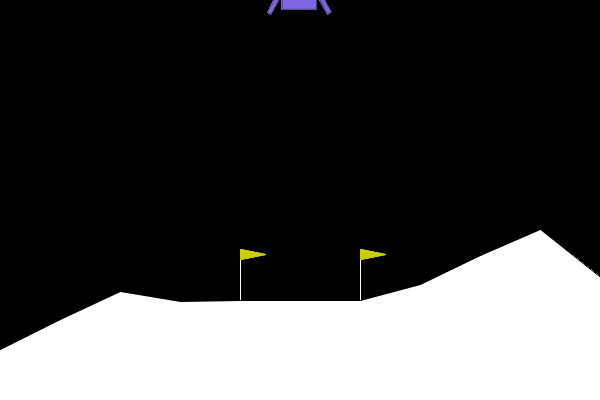

In [6]:
environment .reset()
PIL.Image.fromarray(environment.render(mode='rgb_array'))

In [7]:
t=environment.reset()
for _ in range(10):
  t=np.concatenate((t,environment.reset()),axis=0)

In [ ]:
t.reshape(11,8)

array([[ 0.007,  1.401,  0.663, -0.439, -0.008, -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  1.404,  0.05 , -0.329, -0.001, -0.011,  0.   ,  0.   ],
       [ 0.006,  1.407,  0.61 , -0.19 , -0.007, -0.138,  0.   ,  0.   ],
       [ 0.   ,  1.418,  0.028,  0.305, -0.   , -0.006,  0.   ,  0.   ],
       [ 0.   ,  1.413,  0.011,  0.085, -0.   , -0.002,  0.   ,  0.   ],
       [-0.002,  1.404, -0.186, -0.302,  0.002,  0.042,  0.   ,  0.   ],
       [-0.005,  1.4  , -0.549, -0.478,  0.006,  0.124,  0.   ,  0.   ],
       [-0.006,  1.421, -0.575,  0.451,  0.007,  0.13 ,  0.   ,  0.   ],
       [ 0.002,  1.406,  0.184, -0.232, -0.002, -0.042,  0.   ,  0.   ],
       [ 0.001,  1.414,  0.139,  0.136, -0.002, -0.032,  0.   ,  0.   ],
       [-0.001,  1.403, -0.053, -0.35 ,  0.001,  0.012,  0.   ,  0.   ]],
      dtype=float32)

In [8]:
num_columns, num_rows=5,5

In [9]:
initial_glove_row = np.zeros((1, num_columns))
initial_glove_row[:, num_columns // 2] = 1
test_batch = np.concatenate(
    [
        np.zeros((num_columns, num_rows - 2, num_columns)),
        np.eye(num_columns)[:, None, :],
        num_columns * [initial_glove_row],
    ],
    axis=1,
)

In [10]:
test_batch

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.]]])

In [11]:
test_batch = np.random.rand(10,8)
test_batch

array([[0.277, 0.175, 0.111, 0.141, 0.905, 0.203, 0.231, 0.082],
       [0.726, 0.143, 0.6  , 0.499, 0.692, 0.731, 0.094, 0.688],
       [0.624, 0.181, 0.185, 0.216, 0.818, 0.739, 0.846, 0.739],
       [0.215, 0.517, 0.388, 0.824, 0.402, 0.466, 0.906, 0.751],
       [0.852, 0.778, 0.067, 0.067, 0.545, 0.059, 0.722, 0.67 ],
       [0.759, 0.047, 0.075, 0.174, 0.835, 0.519, 0.184, 0.297],
       [0.385, 0.507, 0.661, 0.005, 0.336, 0.177, 0.279, 0.814],
       [0.805, 0.095, 0.715, 0.896, 0.168, 0.565, 0.351, 0.582],
       [0.822, 0.568, 0.977, 0.619, 0.404, 0.081, 0.343, 0.418],
       [0.376, 0.984, 0.043, 0.915, 0.783, 0.914, 0.651, 0.549]])

In [12]:
# @title Interacting with the environment.

environment = gym.make('LunarLander-v2')

# Create random policy.
def random_policy(obs: chex.Array) -> chex.Array:
  return np.random.randint(environment.action_spec().num_values)

# Simple map from action index to a descriptive string.
int2action = {0: "Do nothing ", 1: "Fire right engine", 2: "Fire main engine",3: "Fire left engine"}

# Reset any counts and start the environment.
environment.reset()
t=environment.reset()
print("First state",t)
done=False
# Run an episode.
Reward=0
while not done:
    #print(environment.observation_space)
    act = environment.action_space.sample()
   # print(f"\nAction: {int2action[act]}\n")
    t=environment.step(act)
    print(f"t{t}")
    state, reward, done, info =t#jnp.asarray(t)
    Reward+=reward
    with np.printoptions(formatter={'float': '{:.3f}'.format}):
      print("Action:", int2action[act],act)
      print("Next State:", state)
      print("Reward Received:", reward)
      print("Episode Terminated:", done)
      print("Info:", info)
    environment.render()
environment.close()
print(f'Total reward:{Reward}')


First state [ 0.     1.415  0.007  0.162 -0.    -0.002  0.     0.   ]
t(array([ 0.   ,  1.418,  0.007,  0.136, -0.   , -0.002,  0.   ,  0.   ],
      dtype=float32), 2.2521834290450897, False, {})
Action: Do nothing  0
Next State: [0.000 1.418 0.007 0.136 -0.000 -0.002 0.000 0.000]
Reward Received: 2.2521834290450897
Episode Terminated: False
Info: {}
t(array([ 0.   ,  1.42 , -0.003,  0.109,  0.002,  0.039,  0.   ,  0.   ],
      dtype=float32), 2.2321855090834233, False, {})
Action: Fire right engine 1
Next State: [0.000 1.420 -0.003 0.109 0.002 0.039 0.000 0.000]
Reward Received: 2.2321855090834233
Episode Terminated: False
Info: {}
t(array([ 0.   ,  1.422, -0.015,  0.082,  0.006,  0.087,  0.   ,  0.   ],
      dtype=float32), 1.9347244777896162, False, {})
Action: Fire right engine 1
Next State: [0.000 1.422 -0.015 0.082 0.006 0.087 0.000 0.000]
Reward Received: 1.9347244777896162
Episode Terminated: False
Info: {}
t(array([-0.   ,  1.423, -0.015,  0.055,  0.01 ,  0.087,  0.   ,  0.

In [ ]:

# import gym
# import numpy as np
# import tensorflow as tf
# import logging
# import imageio

# logging.getLogger().setLevel(logging.ERROR)

# env = gym.make("LunarLander-v2")

# q_network = tf.keras.models.load_model('./Lunar_Lander_model.h5')

# def create_video(filename, env, q_network, fps=30):
#   video = imageio.get_writer(filename, fps=fps)
#   done = False
#   state = env.reset()
#   frame = env.render(mode="rgb_array")
#   video.append_data(frame)
#   while not done:
#     state = np.expand_dims(state, axis=0)
#     q_values = q_network(state)
#     action = np.argmax(q_values.numpy()[0])
#     state, _, done, _ = env.step(action)
#     frame = env.render(mode="rgb_array")
#     video.append_data(frame)
#     for k in range(20):
#       video.append_data(frame)

# filename = "./taxi.mp4"

# create_video(filename, env, q_network)

In [13]:
mkdir "video"

In [14]:
#@title **[Implement]** Uniform Replay Buffer { form-width: "30%" }

@chex.dataclass
class Transition:
  observation: chex.Array
  action: chex.Array
  reward: chex.Array
  done: chex.Array
  next_observation: chex.Array


class ReplayBuffer:
  """Fixed-size buffer to store transition tuples."""

  def __init__(self, buffer_capacity: int):
      """Initialize a ReplayBuffer object.
      Args:
          buffer_capacity (int): maximum allowed size of the replay buffer.
      """
      self._memory = list()
      self._maxlen = buffer_capacity

  @property
  def size(self) -> int:
    # Return the current number of elements in the buffer.
    return len(self._memory)

  def add(self, transition: Transition) -> None:
      """Add a new transition to memory."""
      # Your code here !
      if self.size >= self._maxlen:
        self._memory.pop(0)
      self._memory.append(transition)

  def sample_batch(self, batch_size: int) -> Transition:
    """Randomly sample a batch of experiences from memory."""
    assert len(self._memory) >= batch_size, 'Insuficient number of transitions in replay buffer'
    # Your code here !
    transitions: list[Transition] = random.choices(self._memory, k=batch_size)
    return tree.map_structure(lambda *x: np.stack(x), *transitions)

In [15]:
# @title Test the replay buffer

batch_size = 32
buffer = ReplayBuffer(500000)

for _ in range(batch_size):
  previous_state=environment.reset()
  act = environment.action_space.sample()
   # print(f"\nAction: {int2action[act]}\n")
  state, reward, done, info = environment.step(act)

  buffer.add(
      Transition(
          observation=previous_state,
          action=int2action[act],
          reward=reward or 0.,
          done=done,
          next_observation=state,
      )
  )

assert buffer.sample_batch(batch_size).observation.shape[0] == batch_size

In [16]:
#@title **[Implement]** Catch Network { form-width: "30%" }


environment = gym.make('LunarLander-v2')
num_actions = environment.action_space.n

def LunarLander_network(x: chex.Array):
  # Your code here !
  #out = hk.Flatten()(x)  # For example: [B, 5, 5] -> [B, 25].
  out=x
  out = hk.Linear(256)(out)
  out = jax.nn.relu(out)
  out = hk.Linear(256)(out)
  out = jax.nn.relu(out)
  out = hk.Linear(num_actions)(out)
  return out

# Create the neural network pure functions.
dqn_network = hk.without_apply_rng(hk.transform(LunarLander_network))

In [17]:
#@title **[Implement]** DQN agent

@chex.dataclass
class LearnerState:
  """"Container for all variables needed for training."""
  online_params: hk.Params
  target_params: hk.Params
  opt_state: optax.OptState

class DQNAgent:
  """Implementation of the DQN agent."""

  def __init__(
      self,
      init_params_fn: Callable[[jax.random.KeyArray], hk.Params],
      network_apply_fn: Callable[[hk.Params, chex.Array], chex.Array],
      optimizer: optax.GradientTransformation,
      gamma: float,
      epsilon: float,
      epsilon_dec: float,
      epsilon_end: float,
      num_actions: int,
      buffer_capacity: int,
      batch_size: int,
      target_ema: float,
      seed: int = 0,
  ) -> None:

    """Initializes the DQN agent.

    Args:
      init_params_fn: the pure function which initializes the network parameters.
      network_apply_fn: the pure function corresponding to the desired DQN network.
      optimizer: the optimizer used to minimize the DQN loss.
      gamma: the agent's discount factor.
      epsilon: probability to perform a random exploration when picking a new action.
      num_actions: number of actions in the environment's action space.
      buffer_capacity: capacity of the replay buffer.
      batch_size: batch size when updating the online network.
      target_ema: coefficient for the exponential moving average computation of
        the target network parameters.
      seed: seed of the random generator.
    """
    self._gamma = gamma
    self._epsilon = epsilon
    self.epsilon_dec=epsilon_dec
    self.epsilon_end=epsilon_end
    self._num_actions = num_actions
    self._batch_size = batch_size
    self._target_ema = target_ema

    # Set the neural network and optimizer.
    self._network_apply_fn = network_apply_fn
    self._optimizer = optimizer

    # Initialize the replay buffer.
    self._buffer = ReplayBuffer(buffer_capacity)

    # Always store the current observation so we can create transitions.
    self._observation = None

    # Initialize the network's parameters.
    params = init_params_fn(jax.random.PRNGKey(seed))

    # Initialize the learner state.
    # Your code here !
    self._learner_state = LearnerState(
        online_params=params,
        target_params=jax.tree_map(jnp.copy, params),
        opt_state=self._optimizer.init(params),
    )

    # JIT the update step.
    self._update = jax.jit(self._update_fn)

  def observe_first(self, observation: chex.Array) -> None:
    self._observation = observation

  def select_action(
      self,
      observation: chex.Array,
      eval: bool,
  ) -> chex.Array:
    """Picks the next action using an epsilon greedy policy.

    Args:
      obersation: observed state of the environment.
      eval: if True the agent is acting in evaluation mode (which means it only
        acts according to the best policy it knows.)
    """
    # Fill in this function to act using an epsilon-greedy policy.
    # Your code here !
    if eval or np.random.uniform() > self._epsilon:
      # The network expects a batch dimension so we add one here.
      observation = jnp.expand_dims(observation, axis=0)
      # Greedy action selection.
      q_values = self._network_apply_fn(
          self._learner_state.target_params,
          observation
      )
      # Remove the batch dimension that was added above.
      q_values = jnp.squeeze(q_values, axis=0)
      action = jnp.argmax(q_values, axis=-1)
      #print("Action Selected",action)
    else:
      # Random action selection.
      action = np.random.randint(self._num_actions)

    return int(action)

  def _loss_fn(
      self,
      online_params: hk.Params,
      target_params: hk.Params,
      transition: Transition,
  ) -> chex.Array:
      """Computes the Q-learning loss

      Args:
        online_params: parameters of the online network.
        target_params: parameters of the target network.
        transition: container of transition quantities (s, a, r, done, s')
      Returns:
        The Q-learning loss.
      """
      # Your code here !
      # target_q = self._network_apply_fn(
      #     online_params,
      #     transition.next_observation,
      # )
      # argmax_Action = jnp.argmax(target_q)
      # target_q_values =  self._network_apply_fn(
      #     target_params,
      #     transition.next_observation,
      # )
      # final_target_q = target_q_values[argmax_Action]
      # y = jnp.where(
      #     transition.done,
      #     transition.reward,
      #     transition.reward + self._gamma * jnp.max(target_q_values, axis=-1),
      # )


      target_q_values = self._network_apply_fn(
          target_params,
          transition.next_observation,
      )
      action_with_max_target_q_values = jnp.argmax(target_q_values,axis=-1)

      target_q_values_with_greedy_action=jnp.take_along_axis(
        target_q_values,
        action_with_max_target_q_values[:, None],
        axis=-1,
      )
      y = jax.lax.stop_gradient(jnp.where(
          transition.done,
          transition.reward.reshape(-1),
          transition.reward.reshape(-1) + self._gamma * target_q_values_with_greedy_action.reshape(-1),
      ))
      online_q_values = self._network_apply_fn(
          online_params,
          transition.observation,
      )
      online_q_value_at_action = jnp.take_along_axis(
          online_q_values,
          transition.action[:, None],
          axis=-1,
      )
      online_q_value_at_action = jnp.squeeze(
          online_q_value_at_action,
          axis=-1,
      )
      loss = 0.5 * jnp.mean(jnp.square(y - online_q_value_at_action))

      return loss

  def _update_fn(
      self,
      state: LearnerState,
      batch: Transition,
      epsMin=0.01, epsDecr=5e-5
  ) -> tuple[LearnerState, chex.Array]:
    """Get the next learner state given the current batch of transitions.

    Args:
      state: the current learner state.
      batch: batch of transitions (st, at, rt, done_t, stp1)
    Returns:
      A tuple of:
        - the updated learner state, and
        - the loss incurred by the previous learner state given the batch.
    """
    self.epsDecr=epsDecr
    self.epsMin=epsMin
    # Compute gradients
    # Your code here !
    loss, grad = jax.value_and_grad(self._loss_fn)(
        state.online_params,
        target_params=state.target_params,
        transition=batch
    )

    # Apply gradients
    # Your code here !
    updates, opt_state = self._optimizer.update(grad, state.opt_state)
    online_params = optax.apply_updates(state.online_params, updates)

    # Update target network params as:
    #   target_params <- ema * target_params + (1 - ema) * online_params
    # You code here !
    ema = self._target_ema
    target_params = jax.tree_map(
        lambda online, target: ema * target + (1 - ema) * online,
        online_params,
        state.target_params,
    )

    new_state = LearnerState(
      online_params=online_params,
      target_params=target_params,
      opt_state=opt_state,
    )
    print("self._epsilon",self._epsilon)
    # if self._epsilon-self.epsDecr>self.epsMin:
    #   self._epsilon=self._epsilon-self.epsDecr
    # else:
    #   self._epsilon=self.epsMin

    #self._epsilon = jnp.maximum(self._epsilon-self.epsDecr, self.epsMin)
    print("self._epsilon",self._epsilon)
    return new_state, loss

  def observe(self, action: chex.Array) -> None:
    """Updates the agent from the given observations.

    Args:
      action: action performed at time t.
      timestep: timestep returned by the environment after
    """
    state, reward, done, info = environment.step(action)
    # Create the transition.
    transition = Transition(
        # Current observation.
        observation=self._observation,
        # Action taken given that observation.
        action=action,
        # Result of taking the action.
        reward=reward,
        done=done,
        next_observation=state,
    )
    # Add the transition to the replay buffer.
    self._buffer.add(transition)
    # Update the current observation.
    self._observation = state

  def reduce_epsilon(self):
        # self._epsilon = self._epsilon*self.epsilon_dec if self._epsilon > \
        #                self.epsilon_end else self.epsilon_end
        a=self._epsilon*self.epsilon_dec
        #print("a",a)
        if a>self.epsilon_end:
          self._epsilon=a
        else:
          self._epsilon=self.epsilon_end

        return self._epsilon
  # def save_model(self, path):
  #       torch.save(self.q_func.state_dict(), path)

  def update(self) -> chex.Array | None:
    """Performs an update step if there is enough transitions in the buffer.

    Returns: DQN loss obtained when updating the online network or None if
      there was not enough data.
    """
    if self._buffer.size >= self._batch_size:
      batch = self._buffer.sample_batch(self._batch_size)
      self._learner_state, loss = self._update(self._learner_state, batch)
      epsilon=self.reduce_epsilon()
      return loss,epsilon
    return None,None

In [18]:
# @title Define the acting loop.

def run_dqn_episode(
    dqn_agent: DQNAgent,
    environment,
    eval: bool,
) -> float:
  """Runs a single episode of catch.

  Args:
    dqn_agent: agent to train or evaluate
    env: the Catch environment the agent should interact with.
    eval: evaluation mode.
  Returns:
    The total reward accumulated over the episode.
  """
  # Reset any counts and start the environment.
  state = environment.reset()
  #state, reward, done, info = timestep
  dqn_agent.observe_first(state)
  total_reward = 0
  done=False

  # Run an episode.
  while not done:

    # Generate an action from the agent's policy and step the environment.
    action = dqn_agent.select_action(state[None, ...], eval)
    #print("action",action)
    state, reward, done, info = environment.step(action)

    # If the agent is training (not eval), add the transition to the replay
    # buffer and do an update step.
    if not eval:
      dqn_agent.observe(action)

    total_reward += reward

  return total_reward

In [20]:
#@title Train the DQN agent. { form-width: "30%" }

num_episodes = 10_000
batch_size = 256

# Evaluation hyperparameters.
num_eval_episodes = 10
eval_every_period = 200

# Bind a dummy observation to the init function so the agent doesn't have to.
observation_spec = environment.observation_space
dummy_observation = np.zeros(observation_spec.shape, observation_spec.dtype)
init_params_fn = lambda rng: dqn_network.init(rng, dummy_observation[None, ...])

# Create the agent.
dqn_agent = DQNAgent(
    init_params_fn=init_params_fn,
    network_apply_fn=dqn_network.apply,
    optimizer=optax.adam(learning_rate=0.0005),
    gamma=0.9,
    epsilon=1.0,
    epsilon_dec=0.996,
    epsilon_end=0.01,
    num_actions=environment.action_space.n,
    buffer_capacity=500000,
    batch_size=batch_size,
    target_ema=0.995,
)
    # gamma=.99 # decay rate
    # epsilon=1.0 # exploration rate
    # epsMin=.01 # min exp rate
    # epsDecr=1e-4 # rate of exp decrease
    # batchSize=64
    # lr=.0005 # learning rate
    # c=4 # target network update rate
    # k=1 # batch sampling rate
print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")

# Initialize logged quantities.
episodes = []
all_rewards = []
all_losses = []
online_test_q_values = []
target_test_q_values = []

# Create a test batch of all possible initial observations.
# initial_glove_row = np.zeros((1, num_columns))
# initial_glove_row[:, num_columns // 2] = 1
#test_batch = np.random.rand(10,8)
test_batch =environment.reset()
test_sample=10
for _ in range(test_sample-1):
  test_batch=np.concatenate([test_batch,environment.reset()],axis=0)
test_batch=test_batch.reshape(test_sample,8)
Reward_episode=[]
Epsilon=[]
for episode in range(num_episodes):
  # Run a training episode and then a training step.
  reward_episode=run_dqn_episode(
      dqn_agent,
      environment,
      eval=False
  )
  Reward_episode.append(reward_episode)
  loss,epsilon = dqn_agent.update()

  # Store some important diagnostic metrics to plot later.
  all_losses.append(loss)
  Epsilon.append(epsilon)
  online_test_q_values.append(
      dqn_network.apply(dqn_agent._learner_state.online_params, test_batch)
  )
  target_test_q_values.append(
      dqn_network.apply(dqn_agent._learner_state.target_params, test_batch)
  )

  # Every once in a while, evaluate the greedy policy on a few episodes.
  if episode % eval_every_period == 0:
    reward = np.mean([
        run_dqn_episode(dqn_agent, environment, eval=True)
        for _ in range(num_eval_episodes)
    ])
    # Print how much reward the agent accumulated on average.
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)
    # if (episode+1) % 100 == 0 and episode > 0:
    #         # Save the model every N-th step just in case
    #         agent.save_model('ddqn_torch_model.h5')
    #         # with open("ddqn_torch_dqn_scores_{}.json".format(int(time.time())), "w") as fp:
    #         #     json.dump(scores, fp)
    #         # with open("ddqn_torch_eps_history_{}.json".format(int(time.time())), "w") as fp:
    #         #     json.dump(eps_history, fp)

Episode number:	| Average reward on 10 eval episodes
------------------------------------------------------
	0	|	-918.1406065253128
self._epsilon 1.0
self._epsilon 1.0
	200	|	-412.3228794505475
	400	|	-257.63305198233127
	600	|	-184.5971678637298
	800	|	-168.52809719775115
	1000	|	-163.88270524875327
	1200	|	-81.20666090129116
	1400	|	-20.419213457092177
	1600	|	-44.38900235823097
	1800	|	62.669754785119025
	2000	|	26.64872851772867
	2200	|	5.249637065977913
	2400	|	-92.61559552893719
	2600	|	-102.84713946917546
	2800	|	-93.16296021615848
	3000	|	-52.639450306922086
	3200	|	-81.75861613222798
	3400	|	-73.6784052153845
	3600	|	-67.56283533221318
	3800	|	-71.3033404893159
	4000	|	-51.483400949905295
	4200	|	-39.62559582409463
	4400	|	-42.17322806739489
	4600	|	-32.15851264165391
	4800	|	-25.610897568972973
	5000	|	-17.574859575611523
	5200	|	-27.861149416052193
	5400	|	-35.25351171702452
	5600	|	16.58217567108197
	5800	|	-9.743934225068767
	6000	|	47.60531207823134
	6200	|	-1.02274252523

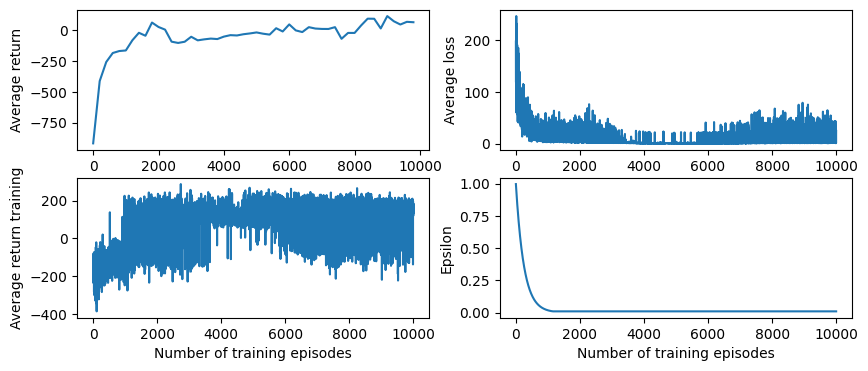

In [21]:
# @title Visualize the evaluation return and the training loss.

fig, axs = plt.subplots(2, 2, figsize=(10, 4))
axs[0,0].set_xlabel('Number of training episodes')
axs[0,0].set_ylabel('Average return')
axs[0,0].plot(episodes, all_rewards)
#axs[0].set_ylim([-1.1, 1.1])
axs[0,1].set_xlabel('Number of updates')
axs[0,1].set_ylabel('Average loss')
axs[0,1].plot(np.asarray(all_losses).T)
#axs[0,1].set_ylim([0, 0.25]);
axs[1,0].set_xlabel('Number of training episodes')
axs[1,0].set_ylabel('Average return training')
axs[1,0].plot(np.arange(num_episodes), Reward_episode)
axs[1,1].set_xlabel('Number of training episodes')
axs[1,1].set_ylabel('Epsilon')
axs[1,1].plot(np.arange(num_episodes), Epsilon)

#Visualize the Q-values at all possible last steps.

8


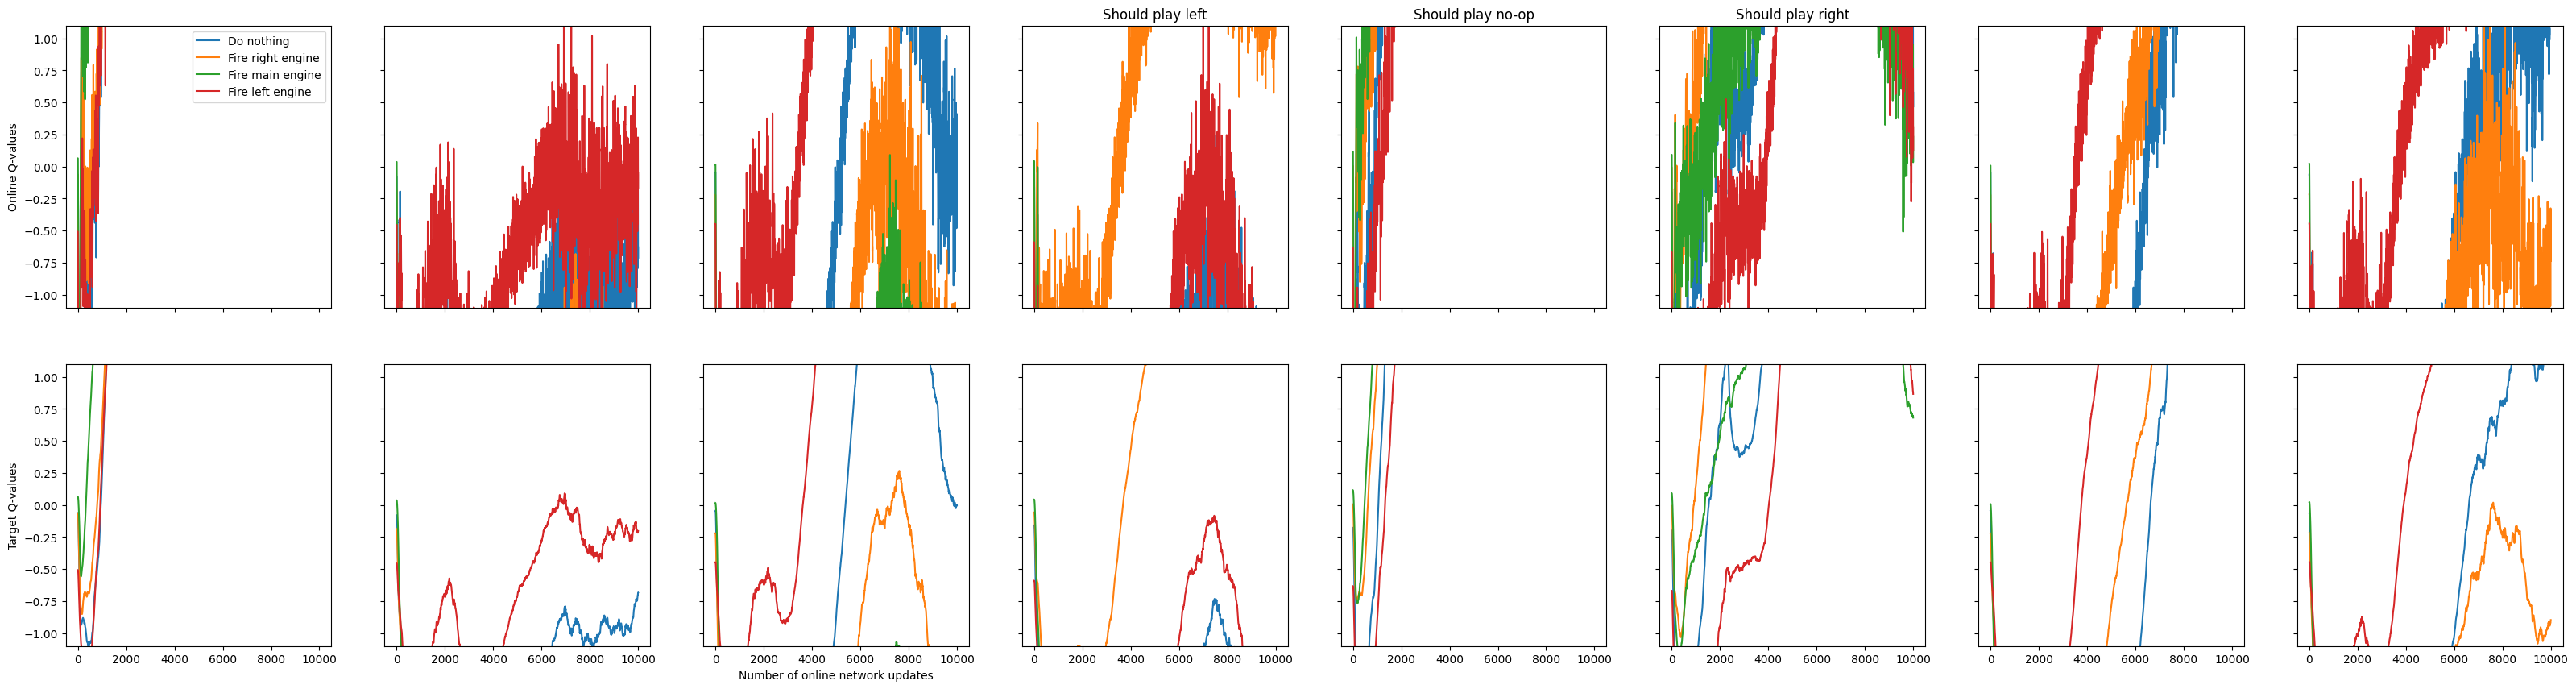

In [29]:
online_test_q_values = np.asarray(online_test_q_values)
target_test_q_values = np.asarray(target_test_q_values)
num_columns=8
print(num_columns)
fig, axs = plt.subplots(2, num_columns, figsize=(num_columns * 5, 10), sharey=True, sharex=True)
plt.ylim([-1.1, 1.1])
axs[0, 0].set_ylabel('Online Q-values')
axs[1, 0].set_ylabel('Target Q-values')
axs[1, 2].set_xlabel('Number of online network updates')
for i in range(num_columns):
  if i == num_columns // 2 - 1:
    should_play = 'left'
  elif i == num_columns // 2:
    should_play = 'no-op'
  elif i == num_columns // 2 + 1:
    should_play = 'right'
  else:
    should_play = None

  axs[0, i].set_title(f'Should play {should_play}' if should_play else None)
  axs[0, i].plot(online_test_q_values[:, i], label=[ "Do nothing ", "Fire right engine", "Fire main engine","Fire left engine"])
  axs[1, i].plot(target_test_q_values[:, i])

  if i == 0:
    axs[0, i].legend()

In [23]:
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [24]:

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = '/content/video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="/content/video/{}.mp4".format(env_name))
    #agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        #PIL.Image.fromarray(frame )
        action = dqn_agent.select_action(state[None, ...], True)
        #print("action",action)
        state, reward, done, info = env.step(action)
    env.close()

In [25]:
show_video_of_model('LunarLander-v2')


In [26]:
show_video('LunarLander-v2')